# Least square approximations

by [Richard Tsai](https://www.researchgate.net/profile/Richard_Tsai3)


## QR factorization

QR factorization finds orthonormal basis of the subspace spanned **successively** by columns of $A$.

$A=QR$ where the columns of $Q$ are orthonormal and $R$ is an upper triangular matrix.

Let $a_j$ be the jth column of $A$ and $q_j$ be the jth column of $Q$.

span$\{a_1,\cdots,a_j\}=$span$\{q_1,\cdots,q_j\}, j=1,2,\cdots,n$

### Use QR factorization to solve the least square problem (=to solve the normal equations):

$A=QR$ 

1. $y:= Q^\top b$
2. Solve $Rx=y$ by back-substitutions.

## Pivoted QR factorization and truncation and applications

QR-factorization can be used to solve both **underdetermined**, 
**square** and **overdetermined**
linear systems of equations. 

It can also be used to compute a numerically 
stable solution of an **ill-conditioned** system.


With pivoted QR-factorization a matrix can be factorized into
$$AP=QR$$
where $P$ is a permutation matrix, making the diagonal elements $r_{i,i}$ in 
the uppertriangular matrix $R$ be ordered in decending order, i.e.
$\vert r_{i,i} \vert \le \vert r_{i-1,i-1} \vert $. 

$Q$ is orthonormal, i.e. $Q^\top Q = I$. Assume the matrix $A$ is $n\times n$. 

In Julia, $Q,R,$ and $P$ can be computed as follows:

```
F=qrfact(A, Val{true}) #Val{true} tells Julia to compute teh pivoted QR factorizaton
Q=F[:Q]
R=F[:R]
P=F[:P]
```

The solution of a linear system of equations $A{\bf x}={\bf b}$ is obtained from 
$$R{\bf y}=Q^T{\bf b}, \quad and \quad {\bf x}=P{\bf y}$$
If the matrix $A$ is ill-conditioned $R$ can be written on block form
$$R=\pmatrix{R_{11}&R_{12}\cr
               0   &E\cr}$$
where 
* $R_{11}$ is an uppertriangular matrices of dimension $r\times r$, 
* $E$ is an uppertriangular matrices of dimension $n-r\times n-r$, and **the elements of 
$E$ are very small**. 
    - The smaller the elements of $E$ are the more 
ill-conditioned is the matrix $A$. 
    - If the elements of $E$ are exactly zero the matrix $A$ is rank-deficient with $rank(A)=r$.
        
By setting small but nonzero elements in $E$ to zero we regard the matrix $A$ 
as rank-deficient even if it isn't that mathematically. Then we cannot 
find a unique solution. But we can, instead, **find a solution with the smallest 2-norm** to
$\hat A \hat{\bf x} = {\bf b}$, where
$$\hat A = Q \pmatrix{R_{11}&R_{12}\cr
                         0  & 0 \cr} P^T$$
according to the following algorithm:

1. Compute the vectors $\hat {\bf d}$ and ${\bf d}_E$ from
$$Q^T {\bf b} =\pmatrix{\hat {\bf d}\cr
                         {\bf d}_E \cr}$$
2. Solve the system 
$$R_{11}\hat {\bf y}=\hat {\bf d}$$
3. Finally compute
$$\hat {\bf x}=P\pmatrix{\hat {\bf y}\cr
                            0\cr}$$


The goal of this exercise is to illustrate the following relations:

1. the sensitivity of the solution $\hat {\bf x}$  from the experimentally computed condition number of $R_{11}$ (see below) as a
function of $r$
2. the condition number of $R_{11}$ computed with Julia's function 'cond( )' as a function of $r$
3. the norm of the matrix $E$ as a function of $r$
4. the norm of the residual ${\bf res}=A \hat {\bf x} - {\bf b}$ as a 
function of $r$

What is important in practice is to find the rank $r$ for
which both the residual ${\bf res}$ and the sensitivity of disturbancies in
**b** are "small". Often this is a compromize; the norm of the residual
increases while the sensitivity (condition number) decreases as the rank $r$
decreases.  


In the following box, a function named 'gen_illposed_system()' is defined. 
It creates an ill-conditioned system $A{\bf x}={\bf b}$.

1. Compute a system of size $n=18$, i.e. $A$ is $18\times 18$ and ${\bf b}$ is
$18\times 1$. 
2. Estimate the condition number $\kappa (A)$ experimentally
from the relation
$${\Vert \Delta {\bf x} \Vert_2 \over \Vert {\bf x} \Vert_2} = 
\kappa (A) {\Vert \Delta b \Vert_2 \over \Vert {\bf  b} \Vert_2}$$
by disturbing ${\bf b}$ with some small perturbances $\Delta {\bf b}$ and see
how ${\bf x}$ is changed, $\Delta {\bf x}$. Compare your result with 
Julia's function `cond()`.
3. Write a program showing a table of the following quantities 
as functions of the rank $r=8,7,6,5$: $\tt norm(E)$, $\tt cond(R_{11})$,
the experimentally computed condition number of $R_{11}$, $\tt norm(x)$,
and $\tt norm(res)$. Express your results in a way that describes the 
behaviour of the relations mentioned above as functions of the rank $r$.



In [73]:
function gen_illposed_system(n)
# ILLPOSED Creates an ill-posed system Ax=b.
#    ILLPOSED(N) creates an ill-posed system of size N.
#    N >= 2
    
    r = max(convert(Int,round(0.25*n)),2)
    U,S,V = svd(rand(n,n))
    S[n-r+1:n]=linspace(1.5e-9,2.45e-12,r)
    A = U*diagm(S)*V'
    b = A*rand(n,1)
    
    return A,b
end

gen_illposed_system (generic function with 1 method)

### Solving least square problems with QR factorization

The least squares method is used to fit functions to measured data. In the
following box, measurements of the $CO_2$-concentration in the athmosphere is
tabulated. 
The concentration is measured in parts per million and is
available for each month from 1980 to 2003. 
The data are tabulated following teh following format:

1980 338.01 338.36 340.08  ........................ 338.21

1981 339.23 340.47 341.38  ........................ 339.61

Hence each row starts with the year, then follows the 12 measurements for
each month. 

Pick out the monthly values (columns 2 to 13) and store them columnwise in Q

```
Q=maunaloa[:,2:13]'```

Put the measurements  in time increasing order in one column

```
b=Q[:] 
using PyPlot
plot(b,"x")```

In [276]:
maunaloa=
[1980 338.01 338.36 340.08 340.77 341.46 341.17 339.56 337.60 335.88 336.01 337.10 338.21;  
1981 339.23 340.47 341.38 342.51 342.91 342.25 340.49 338.43 336.69 336.85 338.36 339.61;
1982 340.75 341.61 342.70 343.56 344.13 343.35 342.06 339.82 337.97 337.86 339.26 340.49; 
1983 341.37 342.52 343.10 344.94 345.75 345.32 343.99 342.39 339.86 339.99 341.16 342.99;
1984 343.70 344.51 345.28 347.08 347.43 346.79 345.40 343.28 341.07 341.35 342.98 344.22;
1985 344.97 346.00 347.43 348.35 348.93 348.25 346.56 344.69 343.09 342.80 344.24 345.56;
1986 346.29 346.96 347.86 349.55 350.21 349.54 347.94 345.91 344.86 344.17 345.66 346.90;
1987 348.02 348.47 349.42 350.99 351.84 351.25 349.52 348.10 346.44 346.36 347.81 348.96; 
1988 350.43 351.72 352.22 353.59 354.22 353.79 352.39 350.44 348.72 348.88 350.07 351.34;
1989 352.76 353.07 353.68 355.42 355.67 355.13 353.90 351.67 349.80 349.99 351.30 352.53;
1990 353.66 354.70 355.39 356.20 357.16 356.22 354.82 352.91 350.96 351.18 352.83 354.21;
1991 354.72 355.75 357.16 358.60 359.34 358.24 356.17 354.03 352.16 352.21 353.75 354.99;
1992 355.98 356.72 357.81 359.15 359.66 359.25 357.03 355.00 353.01 353.31 354.16 355.40;
1993 356.70 357.16 358.38 359.46 360.28 359.60 357.57 355.52 353.70 353.98 355.33 356.80;
1994 358.36 358.91 359.97 361.26 361.68 360.95 359.55 357.49 355.84 355.99 357.58 359.04; 
1995 359.96 361.00 361.64 363.45 363.79 363.26 361.90 359.46 358.06 357.75 359.56 360.70;
1996 362.05 363.25 364.03 364.72 365.41 364.97 363.65 361.49 359.46 359.60 360.76 362.33;
1997 363.18 364.00 364.57 366.35 366.79 365.62 364.47 362.51 360.19 360.77 362.43 364.28;
1998 365.32 366.15 367.31 368.61 369.29 368.87 367.64 365.77 363.90 364.23 365.46 366.97;
1999 368.15 368.87 369.59 371.14 371.00 370.35 369.27 366.94 364.63 365.12 366.67 368.01;
2000 369.14 369.46 370.52 371.66 371.82 371.70 370.12 368.12 366.62 366.73 368.29 369.53;
2001 370.28 371.50 372.12 372.87 374.02 373.30 371.62 369.55 367.96 368.09 369.68 371.24;
2002 372.43 373.09 373.52 374.86 375.55 375.41 374.02 371.49 370.71 370.25 372.08 373.78;
2003 374.68 375.63 376.11 377.65 378.35 378.13 376.62 374.50 372.99 373.00 374.35 375.70];

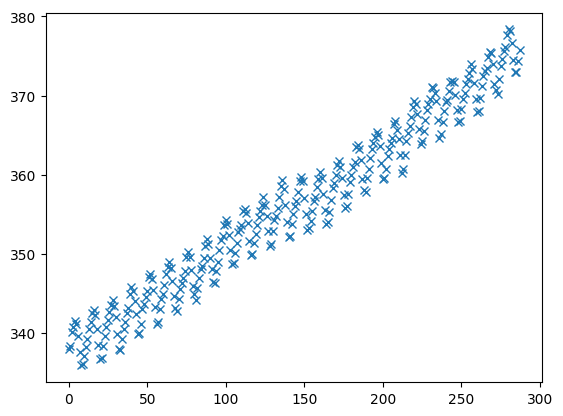

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x137d6fe10>

In [277]:
Q=maunaloa[:,2:13]'

b=Q[:] 

using PyPlot

plot(b,"x")

We observe that the data seems quite oscillatory.
A suitable function to fit to the given data could be
$$y(t)=c_1+c_2e^{\alpha t} + \sum_{k=1}^{np} \left(a_k cos({2\pi kt\over 12}) +
b_k sin({2\pi kt\over 12})\right)$$
where $t$ is in months, $\alpha = 0.00037$. 
**The other parameters to be computed with the least squares method.** 

1. Solve the least square problem for $np=1,2,...,12$ by solving directly the normal equation with the backlash operator. This means `x=(A'A)\(A'b)`. Report also $cond(A'A)$.

2. Use the function `qrfact()` to solve the least squares problem for $np=1,2,\cdots,12$, truncating $A$ to rank $r$, for $r=1,2,\cdots,14$. This means, following the notation in teh previous discussion, $R_{11}$ is is an $r\times r$ matrix . Report also $cond(R_{11})$.

3. Present the computed values of the parameters in each case. Plot out the solutions $y(t)$ against the data points.
Compare your numerical solutions computed in 1. and in 2. Try to explain the discrepancies that you observe.

4. Compute also the residual and write out its 2-norm in each case. Did the residual always decrease as $np$ increases?

5. Perturb the data by a small amount: ` b.+=1e-5*rand(size(b))`, and compare your least square solutions with the ones that you computed without the perturbation. 
